# **Importar librerias**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from math import pi
from scipy import stats, interpolate
import numpy as np
from scipy.integrate import trapezoid

# **Datos**

Vamos analizar los datos del ensayo de tensión de un [acero 1020](https://www.matweb.com/search/DataSheet.aspx?MatGUID=10b74ebc27344380ab16b1b69f1cffbb)


In [2]:
# Cargar los datos

df = pd.read_excel("datos.xlsx")

In [3]:
# Visualizar tabla
df.head()

,Carga [kN],Longitud [mm]
0,0.000000,50.0000
1,0.330776,50.0027
2,0.981932,50.0027
3,1.085901,50.0027
4,1.135960,50.0027


In [4]:
# Tamaño de los datos
df.shape

(373, 2)

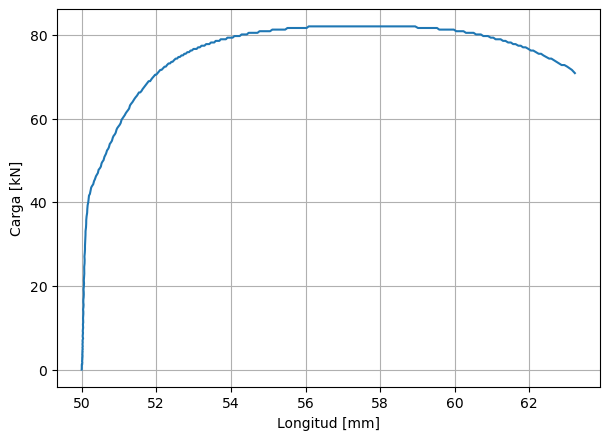

In [5]:
# Gráfica Carga vs Longitud

plt.figure(figsize = (7, 5), dpi = 100)

plt.plot(df["Longitud [mm]"], df["Carga [kN]"])
plt.xlabel("Longitud [mm]")
plt.ylabel("Carga [kN]")
plt.grid()
plt.show()

# **Probeta**

El ensayo se realizó con base en la norma [ASTM E8](https://drive.google.com/file/d/1ycPjdt3DRPj768g6afIgRQUQIBoKkulA/view?usp=sharing) sección 6.9

$L_{0} = 50 mm $

$D_{0} = 12.5 mm $

# **Curva Esfuerzo vs Deformación**




## *Esfuerzo de ingeniería - $\sigma$*

$$\sigma = \frac{F}{A_{0}}$$



In [6]:
# Datos geométricos 

d_0 = 12.5
A_0 = pi * (d_0**2) / 4
A_0

122.7184630308513

In [7]:
df["Esfuerzo [MPa]"] = df["Carga [kN]"] * 1000 / A_0
df.head()

,Carga [kN],Longitud [mm],Esfuerzo [MPa]
0,0.000000,50.0000,0.000000
1,0.330776,50.0027,2.695407
2,0.981932,50.0027,8.001500
3,1.085901,50.0027,8.848718
4,1.135960,50.0027,9.256638


## *Deformación de ingeniería - $\varepsilon$*

$$\varepsilon = \frac{L_i-L_0}{L_0}$$

In [8]:
# Longitud inicial [mm]

L_0 = df["Longitud [mm]"][0]
L_0

50.0

In [9]:
# Deformación

df["Deformación [mm/mm]"] = (df["Longitud [mm]"] - L_0) / L_0
df.head()

,Carga [kN],Longitud [mm],Esfuerzo [MPa],Deformación [mm/mm]
0,0.000000,50.0000,0.000000,0.000000
1,0.330776,50.0027,2.695407,0.000054
2,0.981932,50.0027,8.001500,0.000054
3,1.085901,50.0027,8.848718,0.000054
4,1.135960,50.0027,9.256638,0.000054


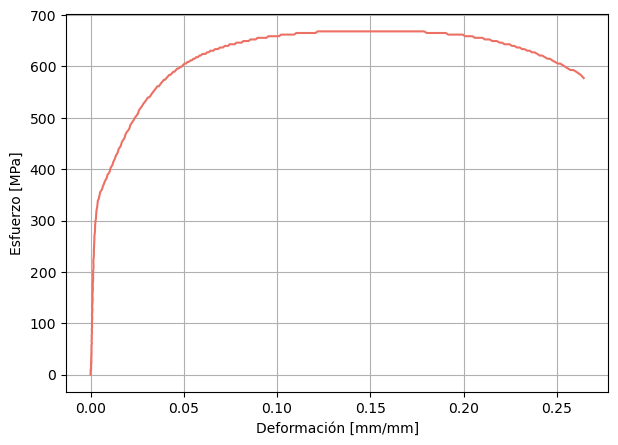

In [10]:
# Gráfica Esfuerzo vs Deformación

plt.figure(figsize = (7, 5), dpi = 100)
plt.plot(df["Deformación [mm/mm]"], df["Esfuerzo [MPa]"], color = "#EC7063")
plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.grid()
plt.show()

# **Propiedades**



## *Módulo de Elasticidad/Módulo de Young - $E$* 
## *(Young's modulus)*

$$ \sigma = E\varepsilon$$

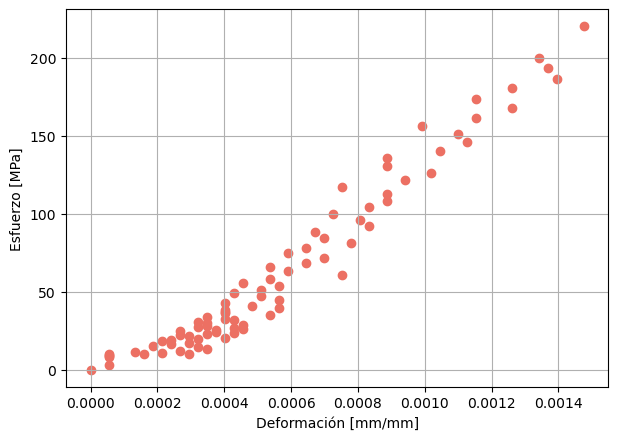

In [11]:
elastico = df[df["Deformación [mm/mm]"] <= 0.15/100]

# Gráfica Zona Elástica
plt.figure(figsize = (7, 5), dpi = 100)
plt.scatter(elastico["Deformación [mm/mm]"], elastico["Esfuerzo [MPa]"], color = "#EC7063", marker = "o")
plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.grid()
plt.show()

### Método de la pendiente

$$ y = mx + b$$



$$m = \frac{y_2 - y_1}{x_2 - x_1} =\frac{\sigma_2 - \sigma_1}{\varepsilon_2 - \varepsilon_1}$$

In [12]:
# Módulo de elasticidad calculado por la pendiente
E_1 =(elastico["Esfuerzo [MPa]"].iloc[-1] - elastico["Esfuerzo [MPa]"].iloc[0]) / (elastico["Deformación [mm/mm]"].iloc[-1] - elastico["Deformación [mm/mm]"].iloc[0])

print(f"El módulo de elasticidad del material es de {E_1/1000:.2f} GPa")

El módulo de elasticidad del material es de 149.24 GPa


### Método de regresión

In [13]:
# Modelo regresión lineal 

modelo = stats.linregress(elastico["Deformación [mm/mm]"], elastico["Esfuerzo [MPa]"])
modelo

LinregressResult(slope=154039.3487190656, intercept=-23.193321996825418, rvalue=0.9732501230045275, pvalue=3.783188906736965e-54, stderr=4015.6166309376117, intercept_stderr=2.684043161187463)

In [14]:
# Pendiente
E_2 = modelo.slope
print(f"El módulo de elasticidad del material es de {E_2/1000:.2f} GPa")

El módulo de elasticidad del material es de 154.04 GPa


In [15]:
# Intercepto
modelo.intercept

-23.193321996825418

Una forma de ver qué tan bien se ajusta un modelo de regresión lineal es con el [$R^{2}$](https://towardsdatascience.com/data-science-explaining-r%C2%B2-in-statistics-6f34e7f0a9bb)



In [16]:
# R2
modelo.rvalue**2

0.9472158019283279

### Comparar pendientes

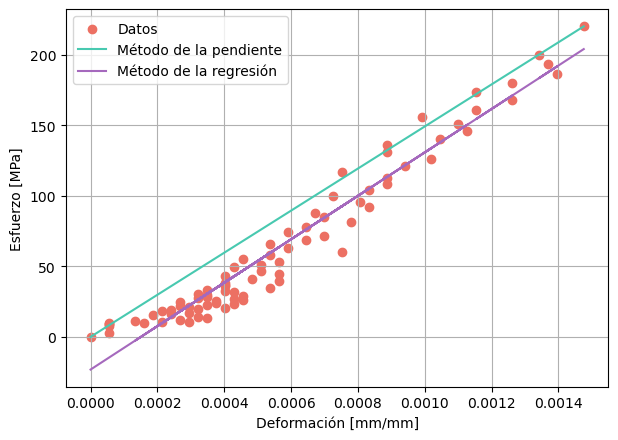

In [17]:
# Comparación de las pendientes

plt.figure(figsize = (7, 5), dpi = 100)

plt.scatter(elastico["Deformación [mm/mm]"], elastico["Esfuerzo [MPa]"], color = "#EC7063", marker = "o", label = "Datos")

plt.plot([elastico["Deformación [mm/mm]"].iloc[0], elastico["Deformación [mm/mm]"].iloc[-1]],
         [E_1*elastico["Deformación [mm/mm]"].iloc[0], E_1*elastico["Deformación [mm/mm]"].iloc[-1]],
         color = "#48C9B0",
         label = "Método de la pendiente")

plt.plot(elastico["Deformación [mm/mm]"], E_2*elastico["Deformación [mm/mm]"] + modelo.intercept,
         color = "#A569BD",
         label = "Método de la regresión")

plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 0)
plt.grid()
plt.show()

## *Esfuerzo de Fluencia - $\sigma_Y$*
## *(Yield strength)*



### Método del 0.2%

In [18]:
# Intercepto Offset 

intercepto = -E_2 * 0.2/100
intercepto

-308.0786974381312

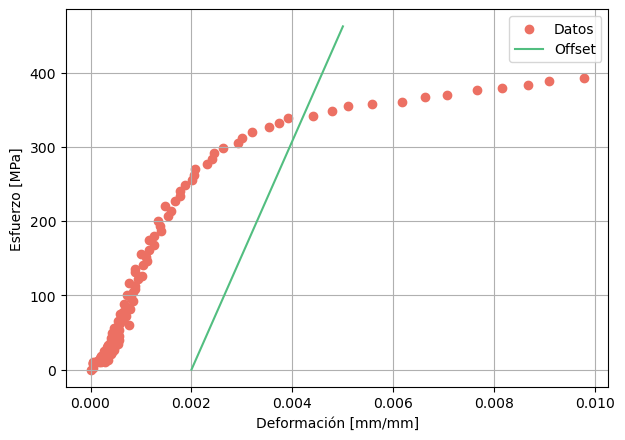

In [19]:
fluencia = df[df["Deformación [mm/mm]"] <= 1/100]

# Gráfica Zona Elástica
plt.figure(figsize = (7, 5), dpi = 100)

plt.scatter(fluencia["Deformación [mm/mm]"], fluencia["Esfuerzo [MPa]"], color = "#EC7063", marker = "o", label = "Datos")

plt.plot([0.2/100, 0.5/100], [E_2*0.2/100 + intercepto, E_2*0.5/100 + intercepto],
         color = "#52BE80",
         label = "Offset")


plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 0)
plt.grid()
plt.show()

In [20]:
# Regresión polinómica

modelo_pol = np.polyfit(fluencia["Deformación [mm/mm]"], fluencia["Esfuerzo [MPa]"], 3)
modelo_pol

array([ 1.60589498e+09, -3.08746836e+07,  1.93772030e+05, -3.18324431e+01])

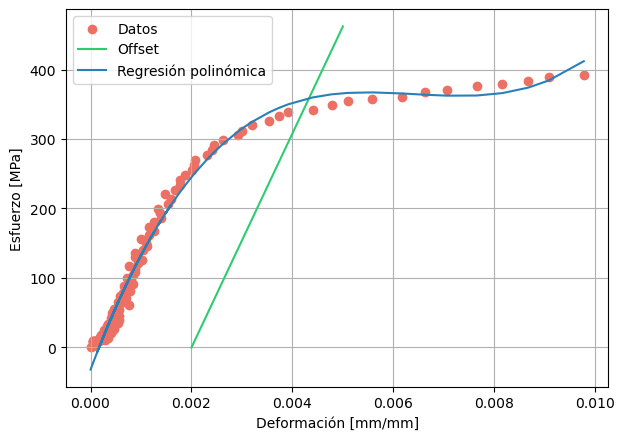

In [21]:
# Gráfica

plt.figure(figsize = (7, 5), dpi = 100)

plt.scatter(fluencia["Deformación [mm/mm]"], fluencia["Esfuerzo [MPa]"], color = "#EC7063", marker = "o", label = "Datos")

plt.plot([0.002, 0.005], [E_2*0.002 + intercepto, E_2*0.005 + intercepto], color = "#2ECC71", label = "Offset")

plt.plot(fluencia["Deformación [mm/mm]"], np.polyval(modelo_pol,fluencia["Deformación [mm/mm]"]), color = "#2980B9", label = "Regresión polinómica")


plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 0)
plt.grid()
plt.show()

El polinomio tiene la forma

$$y = C_0 + C_1x + C_2x^{2} + C_3x^{3}$$

In [22]:
# Coeficientes 

C_0 = modelo_pol[3]
C_1 = modelo_pol[2]
C_2 = modelo_pol[1]
C_3 = modelo_pol[0]

C_0, C_1, C_2, C_3

(-31.832443079092297,
 193772.02977698648,
 -30874683.55156603,
 1605894981.8482466)

Vamos a solucionar la siguiente ecuación

$$ C_0 + C_1x + C_2x^{2} + C_3x^{3} = Ex + b $$

$$C_3x^{3} + C_2x^{2} + (C_1x - Ex) + (C_0 - b)= 0$$

In [23]:
# Raices del polinomio

coeficientes = [C_3, C_2, C_1 - E_2, C_0 - intercepto]
raices = np.roots(coeficientes)
raices

array([ 0.01720696,  0.00432849, -0.00230961])

In [24]:
# Deformación a la fluencia

e_y = raices[1]

print(f"La deformación a la fluencia es de {e_y:.5f} [mm/mm] o {e_y*100:.2f} %")


La deformación a la fluencia es de 0.00433 [mm/mm] o 0.43 %


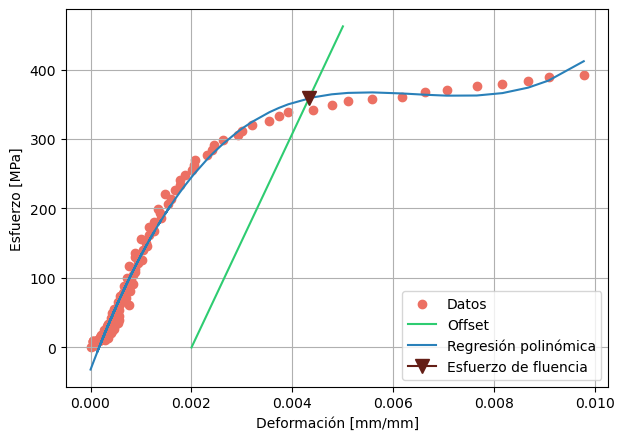

In [25]:
# Gráfica

plt.figure(figsize = (7, 5), dpi = 100)

plt.scatter(fluencia["Deformación [mm/mm]"], fluencia["Esfuerzo [MPa]"], color = "#EC7063", marker = "o", label = "Datos")

plt.plot([0.002, 0.005], [E_2*0.002 + intercepto, E_2*0.005 + intercepto], color = "#2ECC71", label = "Offset")

plt.plot(fluencia["Deformación [mm/mm]"], np.polyval(modelo_pol,fluencia["Deformación [mm/mm]"]), color = "#2980B9", label = "Regresión polinómica")

plt.plot(raices[1], np.polyval(modelo_pol, e_y), color = "#641E16", marker = "v", markersize = 10, label = "Esfuerzo de fluencia")


plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 4)
plt.grid()
plt.show()

In [26]:
# Esfuerzo de fluencia

s_y = np.polyval(modelo_pol, e_y)
print(f"El esfuerzo de fluencia es de {s_y:.2f} MPa")

El esfuerzo de fluencia es de 358.68 MPa


### *Esfuerzo Último - $\sigma_U$*
### *(Tensile strength)*

In [27]:
# Esfuerzo último 

s_u = max(df["Esfuerzo [MPa]"])
print(f"El esfuerzo de último es de {s_u:.2f} MPa")

El esfuerzo de último es de 668.36 MPa


In [28]:
# Datos de esfuerzo último 

ultimo = df[df["Esfuerzo [MPa]"] == s_u]
ultimo

,Carga [kN],Longitud [mm],Esfuerzo [MPa],Deformación [mm/mm]
258,82.020189,56.085,668.360626,0.1217
259,82.020189,56.135,668.360626,0.1227
260,82.020189,56.190,668.360626,0.1238
261,82.020189,56.245,668.360626,0.1249
262,82.020189,56.295,668.360626,0.1259
263,82.020189,56.350,668.360626,0.1270
264,82.020189,56.405,668.360626,0.1281
265,82.020189,56.455,668.360626,0.1291
266,82.020189,56.515,668.360626,0.1303
267,82.020189,56.570,668.360626,0.1314


In [29]:
# Deformación a la maxima tensión

e_u = np.mean(ultimo["Deformación [mm/mm]"])
print(f"La deformación a máxima tensión es de {e_u:.5f} [mm/mm] o {e_u*100:.2f} %")


La deformación a máxima tensión es de 0.14956 [mm/mm] o 14.96 %


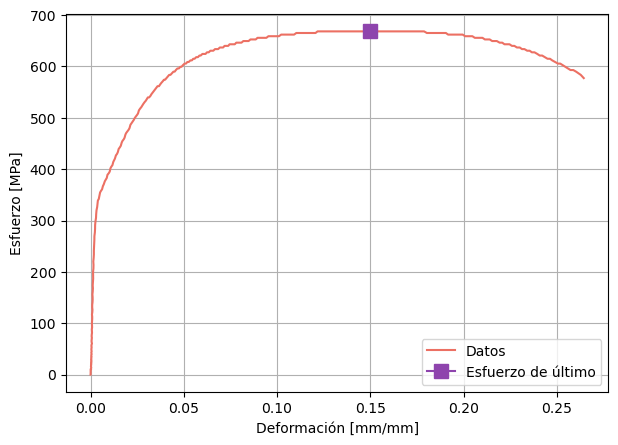

In [30]:
# Gráfica 
plt.figure(figsize = (7, 5), dpi = 100)

plt.plot(df["Deformación [mm/mm]"], df["Esfuerzo [MPa]"], color = "#EC7063", label = "Datos")

plt.plot(e_u, s_u, color = "#8E44AD", marker = "s", markersize = 10, label = "Esfuerzo de último")


plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 4)
plt.grid()
plt.show()

### *Esfuerzo de falla - $\sigma_F$*
### *(Failure strength)*


In [31]:
# Esfuerzo de falla

s_f = df["Esfuerzo [MPa]"].iloc[-1]
print(f"El esfuerzo de falla es de {s_f:.2f} MPa")

El esfuerzo de falla es de 577.36 MPa


### *Deformación de falla - $\varepsilon_F$*
### *(Failure strain)*


In [32]:
# Deformación de falla

e_f = df["Deformación [mm/mm]"].iloc[-1]
print(f"La deformación a la falla es {e_f:.5f} [mm/mm] o {e_f*100:.2f} %")

La deformación a la falla es 0.26440 [mm/mm] o 26.44 %


## *Ductilidad - Elongación*

$$EL = \left(\frac{L_f-L_0}{L_0}\right)X100$$



$$L_f = 54.322 mm$$

In [33]:
# Elongación

EL =(54.322 - 50)/50 * 100

print(f"La elongación es de  {EL:.2f} %")

La elongación es de  8.64 %


## *Reducción de área*

$$RA = \left(\frac{A_0-A_f}{A_0}\right)X100$$


$$D_f = 9.9 mm$$

In [34]:
# Reducción de área 

RA = (12.5**2 - 9.9**2)/(12.5**2) * 100

print(f"La reducción de área es de  {RA:.2f} %")

La reducción de área es de  37.27 %


### Resiliencia - $U_T$

<img src = "https://www.e-education.psu.edu/matse81/sites/www.e-education.psu.edu.matse81/files/images/lesson04/resilience.png" width="300" >


$$U_r \cong \frac{1}{2}\sigma_Y\varepsilon_Y$$

In [35]:
# Resilencia

u_r = 0.5 * s_y * e_y
print(f"La resiliencia es de {u_r:.4f} J/m3")

La resiliencia es de 0.7763 J/m3


### Módulo de Tenacidad - $T$

<img src = "https://i.ytimg.com/vi/JyZmIO1EzMU/maxresdefault.jpg" width= "500" >



In [36]:
# Datos de esfuerzo y deformación

datos = df[["Deformación [mm/mm]", "Esfuerzo [MPa]"]]
datos = datos.sort_values(by = "Deformación [mm/mm]")
datos

,Deformación [mm/mm],Esfuerzo [MPa]
0,0.000000,0.000000
1,0.000054,2.695407
2,0.000054,8.001500
3,0.000054,8.848718
4,0.000054,9.256638
...,...,...
368,0.258800,593.052387
369,0.260300,589.914544
370,0.261600,586.776700
371,0.262800,583.638857


In [37]:
# Borrar duplicados

datos.drop_duplicates(subset = ["Deformación [mm/mm]"], inplace = True)
datos

,Deformación [mm/mm],Esfuerzo [MPa]
0,0.000000,0.000000
1,0.000054,2.695407
9,0.000134,11.358993
6,0.000161,9.946963
13,0.000188,15.344054
...,...,...
368,0.258800,593.052387
369,0.260300,589.914544
370,0.261600,586.776700
371,0.262800,583.638857


### Método de integración polinómica

In [38]:
# Regresión polinómica

modelo_2 = np.polyfit(datos["Deformación [mm/mm]"], datos["Esfuerzo [MPa]"], 7)
modelo_2

array([ 2.40845711e+09, -2.34802989e+09,  9.18977638e+08, -1.84828993e+08,
        2.03345699e+07, -1.21409827e+06,  3.77692130e+04,  9.98967543e+01])

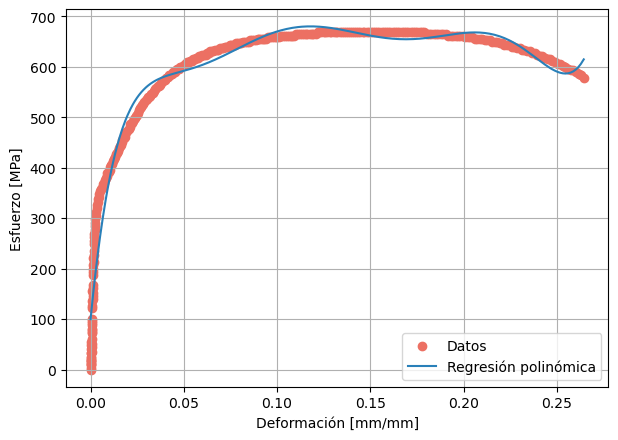

In [39]:
# Gráfica
plt.figure(figsize = (7, 5), dpi = 100)

plt.scatter(datos["Deformación [mm/mm]"], datos["Esfuerzo [MPa]"], color = "#EC7063", marker = "o", label = "Datos")


plt.plot(datos["Deformación [mm/mm]"], np.polyval(modelo_2,datos["Deformación [mm/mm]"]), color = "#2980B9", label = "Regresión polinómica")


plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 4)
plt.grid()
plt.show()

In [40]:
# Integración

p = np.poly1d(modelo_2)
i = p.integ()
i

poly1d([ 3.01057138e+08, -3.35432841e+08,  1.53162940e+08, -3.69657986e+07,
        5.08364248e+06, -4.04699425e+05,  1.88846065e+04,  9.98967543e+01,
        0.00000000e+00])

In [41]:
# Cálculo de la tenacidad

u_t_1 = i(max(datos["Deformación [mm/mm]"])) - i(min(datos["Deformación [mm/mm]"]))

print(f"El módulo de tenacidad es de {u_t_1:.3f} J/m3")

El módulo de tenacidad es de 162.808 J/m3


### Método de interpolación Spline

In [42]:
# Interpolación Spline

modelo_spline = interpolate.splrep(datos["Deformación [mm/mm]"], datos["Esfuerzo [MPa]"])

In [43]:
# Nuevos datos de esfuerzo

s_new = interpolate.splev(datos["Deformación [mm/mm]"], modelo_spline)

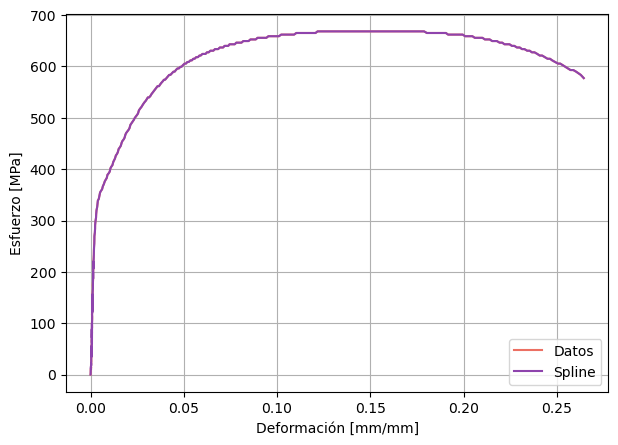

In [44]:
# Gráfica

plt.figure(figsize = (7, 5), dpi = 100)

plt.plot(df["Deformación [mm/mm]"], df["Esfuerzo [MPa]"], color = "#EC7063", label = "Datos")

plt.plot(datos["Deformación [mm/mm]"], s_new, color = "#8E44AD", label = "Spline")


plt.xlabel("Deformación [mm/mm]")
plt.ylabel("Esfuerzo [MPa]")
plt.legend(loc = 4)
plt.grid()
plt.show()

In [45]:
# Módulo de tenacidad

u_t_2 = interpolate.splint(min(df["Deformación [mm/mm]"]), max(df["Deformación [mm/mm]"]), 
                           modelo_spline)

print(f"El módulo de tenacidad es de {u_t_2:.3f} J/m3")

El módulo de tenacidad es de 163.102 J/m3


### Método de intregración por trapezoides

<img src = "https://www.bragitoff.com/wp-content/uploads/2015/08/TrapezoidRule1.png" width= "300" >


In [46]:
# Integración por trapezoides

u_t_3 = trapezoid(y = datos["Esfuerzo [MPa]"],
                  x = datos["Deformación [mm/mm]"])

print(f"El módulo de tenacidad es de {u_t_3:.3f} J/m3")

El módulo de tenacidad es de 163.098 J/m3


# **Resumen de propiedades del ensayo de tensión**

* $E = 154.04  GPa$
* $\sigma_Y = 358.68  MPa$
* $\varepsilon_Y = 0.43 \%$
* $\sigma_U = 668.36  MPa$
* $\varepsilon_U = 14.96 \%$
* $\sigma_F = 577.36  MPa$
* $\varepsilon_F = 26.44 \%$
* $EL = 8.64 \%$
* $RA = 37.27 \%$
* $U_R = 0.7763 \frac{J}{m^3}$
* $U_T = 163.102 \frac{J}{m^3}$